# Ансамбли

Постановка задачи:

Есть 10 объектов, в реальности все принадлежат классу 1:

<font color=2BA8E0 size=30>1111111111</font>

Пусть у нас есть три **независимых** классификатора. Каждый предсказывает верный класс в 70% случаев.

Мы хотим получить общий классификатор на основании этих трех. Будем аггрегировать предсказания классификаторов.

Например, усреднять предсказания:

$$\large h(x) = \dfrac 1 T \sum_{i=1}^{T}a_i(x) $$

Посчитаем вероятность того, что:

 1. Все три классификатора верны: $0.7 * 0.7 * 0.7 = 0.3429$
 2. Два классификатора верны: $0.7 * 0.7 * 0.3 + 0.7 * 0.3 * 0.7 + 0.3 * 0.7 * 0.7 = 0.4409$

Таким образом, если брать большинство голосов, то мы будем в ~78% случаев предсказывать верно.



Мы взяли 3 классификатора, если взять больше классификаторов, то ситуация будет еще лучше.


Пусть теперь у нас три классификатора, выдающие следующие предсказания

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — $80\%$ точность

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — $80\%$ точность

<font color=2BA8E0 size=30>1</font></font><font color=red size=30>0</font><font color=2BA8E0 size=30>111111</font><font color=red size=30>00</font> — $70\%$ точность

Если объединим предсказания, то получим:

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — $80\%$ точность

Потому что очень **высокая зависимость предсказаний**. Выше видно, что два классификатора предсказывают абсолютно одинаково. Вероятность, что они делают это случайно, очень мала.

А вот если возьмем такие классификаторы, то все получится:

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — $80\%$ точность

<font color=red size=30>0</font><font color=2BA8E0 size=30>111</font><font color=red size=30>0</font><font color=2BA8E0 size=30>111</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1</font> — $70\%$ точность

<font color=2BA8E0 size=30>1</font><font color=red size=30>000</font><font color=2BA8E0 size=30>1</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1111</font> — $60\%$ точность


Усреднение:

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1</font> — $90\%$ точность

Реализуем эксперимент зависимости качества ансамбля от качества индивидуального предсказателя и от числа предсказателей:

In [1]:
import numpy as np


def get_predictions(y_real, p, cnt):
    size = y_real.shape[0]
    guessed = np.random.choice([True, False], (cnt, size), p=[p, 1 - p])
    y = np.repeat(y_real.reshape(1, -1), cnt, axis=0)
    y[~guessed] = 1 - y[~guessed]
    return y

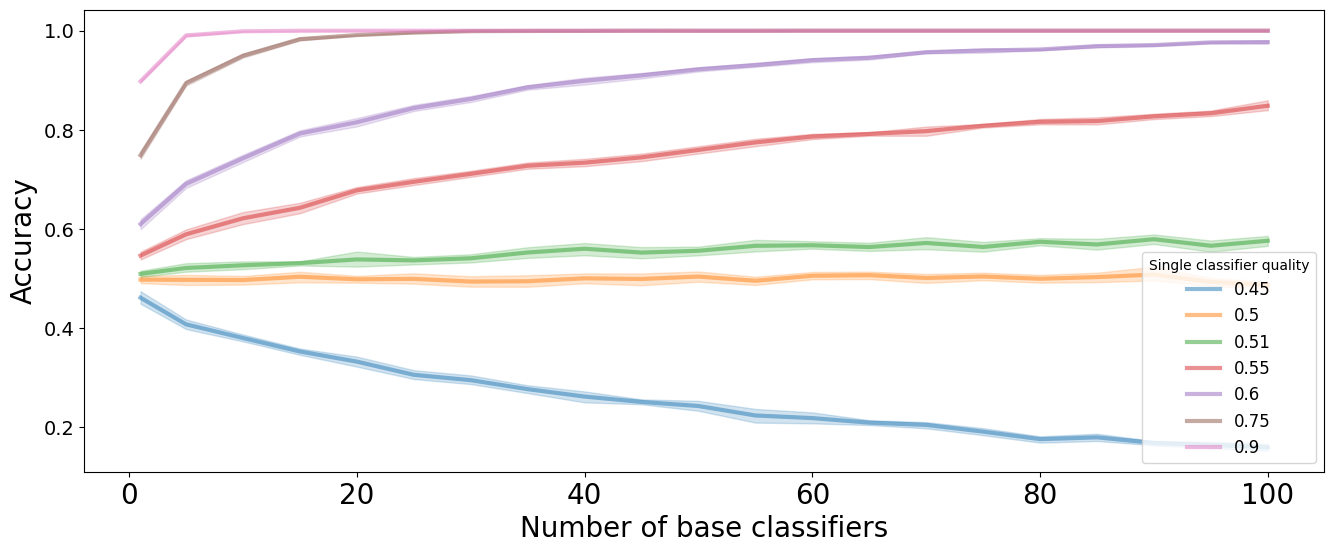

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

size = 1000
reps = 10

cnt_base_predictors = [1] + list(range(5, 105, 5))
single_qual = [0.45, 0.5, 0.51, 0.55, 0.6, 0.75, 0.9]

dt = {"cnt": [], "single_qual": [], "accuracy": []}

for i in range(reps):
    y_real = np.random.choice([0, 1], size)
    for cnt in cnt_base_predictors:
        for p in single_qual:
            preds = get_predictions(y_real, p, cnt)
            voting = np.round(preds.mean(axis=0))
            accuracy = (y_real == voting).mean()
            dt["cnt"].append(cnt)
            dt["single_qual"].append(f"{p:.02}")
            dt["accuracy"].append(accuracy)

results = pd.DataFrame(dt)

plt.figure(figsize=(16, 6))

sns.lineplot(data=results, x="cnt", y="accuracy", hue="single_qual", lw=3, alpha=0.5)
plt.xlabel("Number of base classifiers", size=20)
plt.ylabel("Accuracy", size=20)
plt.legend(loc="best", fontsize=12, title="Single classifier quality")
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)
plt.show()

Видим, что:
1. Чем лучше базовый классификатор, тем меньше нужно классификаторов при прочих равных условиях для достижения высокого качества.
2. Если качество базового классификатора даже чуть больше 0.5, то качество ансамбля растет с увеличением числа моделей в ансамбле.
3. Если качество базового классификатора неотличимо от случайного (0.5), то качество ансамбля будет оставаться равным 0.5.
4. Если качество базового классификатора ниже случайного (0.5), то качество ансамбля стремится к 0.

### Коррелированность моделей


Посмотрим, как зависит качество предсказания от коррелированности предсказателей. Конкретно — от ожидаемой коррелированности вероятностей ошибиться на данном объекте для любой взятой пары классификаторов из ансамбля.

In [3]:
import scipy


def get_correlated_predictions(y_real, p, cnt, r):
    size = y_real.shape[0]
    x1 = np.random.uniform(0, 1, size)
    x2 = np.random.uniform(0, 1, (cnt, size))
    q = np.sqrt(r)
    y = q * x1 + (1 - q**2) ** 0.5 * x2  # y variables now correlated with correlation=r
    y_mod = np.zeros_like(y)
    for i in range(y.shape[0]):
        y_mod[i] = scipy.stats.rankdata(y[i])

    y = y_mod / size  # back to uniform, slightly affects correlations

    y_pred = np.repeat(y_real.reshape(1, -1), cnt, axis=0)
    y_pred[y < 1 - p] = 1 - y_pred[y < 1 - p]  # to predictions, affects correlations
    return y_pred

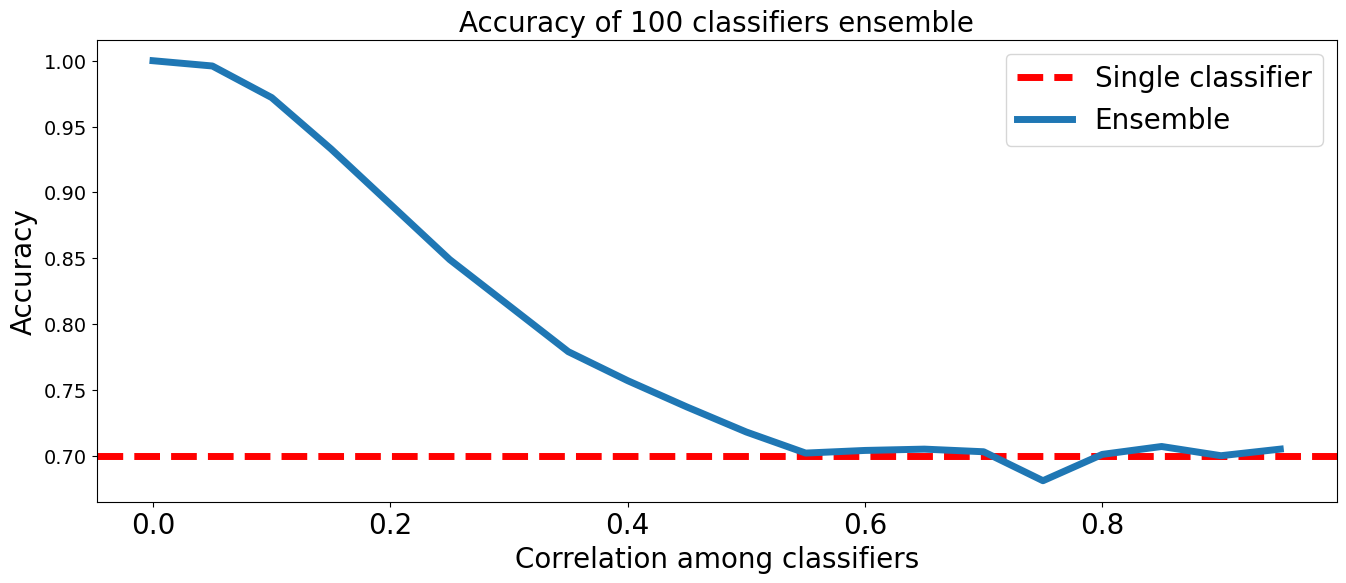

In [4]:
np.random.seed(42)
x = np.arange(0, 1, 0.05)
accuracy = np.zeros_like(x)
p = 0.7
cnt = 100
for ind, r in enumerate(x):
    preds = get_correlated_predictions(y_real, p, cnt, r)
    voting = np.round(preds.mean(axis=0))
    accuracy[ind] = (y_real == voting).mean()

plt.figure(figsize=(16, 6))
plt.title(f"Accuracy of {cnt} classifiers ensemble", size=20)
plt.xlabel("Correlation among classifiers", size=20)
plt.ylabel("Accuracy", size=20)
plt.axhline(y=p, color="red", lw=5, ls="--", label="Single classifier")
sns.lineplot(x=x, y=accuracy, lw=5, label="Ensemble")
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)
plt.show()

Видим, что по мере увеличения коррелированности моделей качество все больше и больше приближается к качеству одной базовой модели.

## Bagging = **B**ootstrap **agg**regat**ing**

Нам нужны классификаторы, которые сами по себе предсказывают лучше, чем случайные, при этом они должны быть не коррелированы. На самом деле это нетривиальная задача: откуда нам брать разные классификаторы, если у нас один датасет?


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/bagging.png" width="600"/></center>

Первый вариант — нам поможет bootstrap:

1. Делаем из нашего исходного датасета N выборок такого же размера с повторениями.

2. На каждой **псевдовыборке** строим отдельную модель. Чтобы полученные модели были слабо зависимы, будем использовать алгоритм, который чувствителен к небольшим изменениям в выборке.

3. Получаем N слабо зависимых моделей.

4. Когда нам нужно сделать предсказание для нового объекта, делаем предсказание каждой из N моделей, а затем усредняем предсказание.

Применим бэггинг для классификации сердечных заболеваний.

В `sklearn.ensemble` реализованы классы `BaggingClassifier` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) и `BaggingRegressor` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html), реализующие алгоритм бэггинга.

In [5]:
heart_dataset = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/heart.csv"
)

In [6]:
from sklearn.model_selection import train_test_split

x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"] > 0
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [7]:
from sklearn.utils import resample

def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)

    for sample in range(samples_cnt):
        x_boot, y_boot = resample(x, y, replace=True, n_samples=x.shape[0])
        b_metric[sample] = metric_fn(x_boot, y_boot)

    return b_metric

In [ ]:
import sklearn
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

models = {}

models["LogReg"] = GridSearchCV(
    LogisticRegression(solver="liblinear", max_iter=100000),
    {"penalty": ("l1", "l2"), "C": [0.01, 0.1, 1, 10, 100]},
).fit(x_train, y_train)

# few objects in the leaf - poor estimates of class probabilities - the model is overtraining
models["DT"] = GridSearchCV(
    DecisionTreeClassifier(),
    {"max_depth": [1, 3, 5, 7, 10], "min_samples_leaf": [1, 3, 5, 10]},
).fit(x_train, y_train)

models["Bagging LogReg"] = BaggingClassifier(
    estimator=models["LogReg"].best_estimator_, n_estimators=100, random_state=42
).fit(x_train, y_train)

models["Bagging DT"] = BaggingClassifier(
    estimator=models["DT"].best_estimator_, n_estimators=100, random_state=42
).fit(x_train, y_train)

In [ ]:
from sklearn.metrics import average_precision_score

predictions = {}
boot_scores = {}

for name, model in models.items():
    predictions[name] = model.predict_proba(x_test)[:, 1]
    boot_scores[name] = bootstrap_metric(
        y_test.values,
        predictions[name],
        metric_fn=average_precision_score,  # PR-AUC
    )

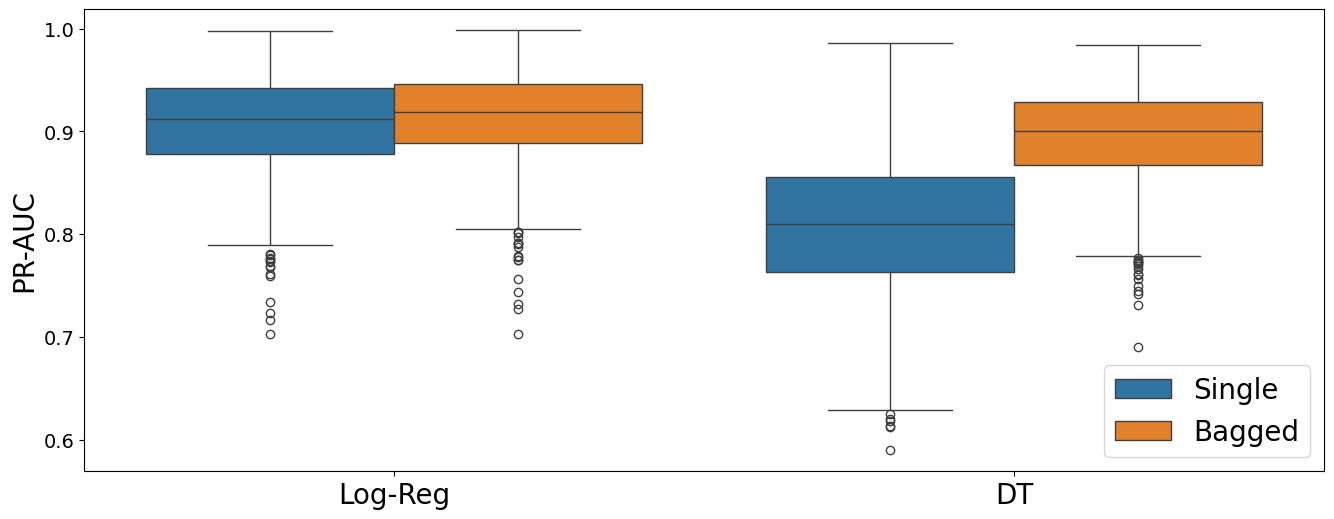

In [ ]:
plt.figure(figsize=(16, 6))

base_models = ["Log-Reg", "DT"] * 2
ensemble_types = ["Single"] * 2 + ["Bagged"] * 2
dfs = []
for i, model_name in enumerate(boot_scores):
    df = pd.DataFrame(boot_scores[model_name], columns=["pr_auc"])
    df["base_model"] = base_models[i]
    df["ensemble_method"] = ensemble_types[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="pr_auc", x="base_model", hue="ensemble_method")
plt.xlabel("", size=20)
plt.ylabel("PR-AUC", size=20)
plt.legend(fontsize=20, loc="lower right")
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)
plt.show()

Дереву решений при ансамблировании удается получить качество не хуже, чем у логистической регрессии. При этом качество логистической регрессии при ансамблировании меняется незначительно.

Сравненим разделяющие поверхности дерева решений и бэггинга на деревьях решений:

In [ ]:
from sklearn import datasets

x, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(
    clf, x, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.85, contour=True, bolded=False
):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    x_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(x_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#FEE7D0", "#bea6ff", "#B8E1EC"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#FEE7D0", "#5D5DA6", "#B8E1EC"])
        if bolded:
            custom_cmap2 = ListedColormap(["#FEE7D0", "#5D5DA6", "#000000"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2)
    plt.plot(x[:, 0][y == 0], x[:, 1][y == 0], "D", c="#F9B041", alpha=alpha)
    plt.plot(x[:, 0][y == 1], x[:, 1][y == 1], "o", c="#2DA9E1", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

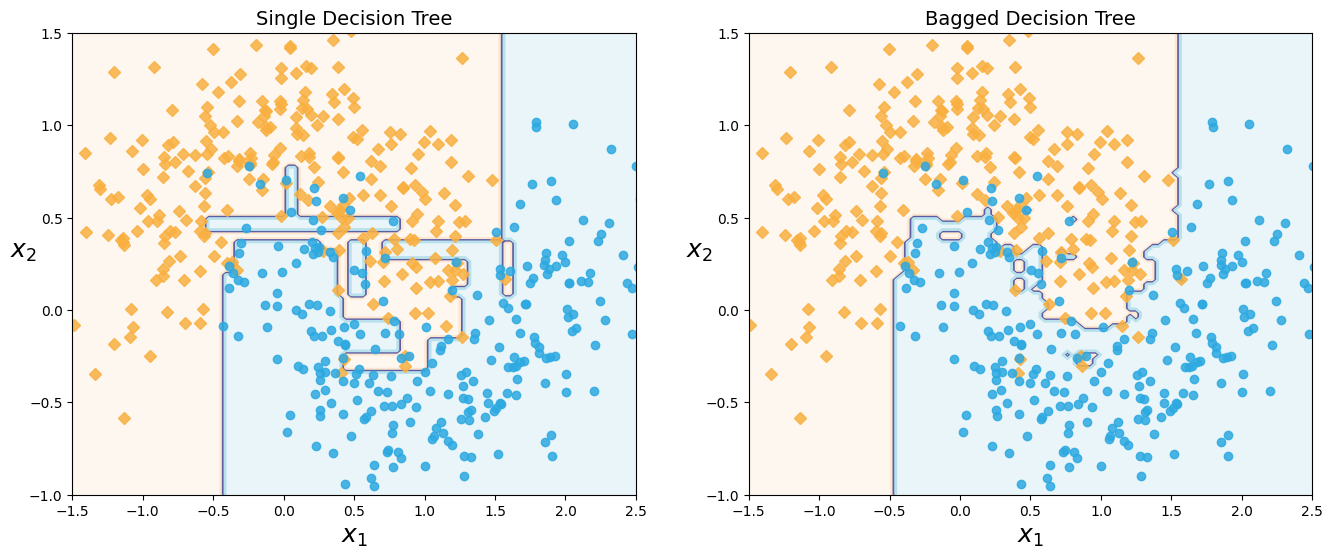

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(x_train, y_train)
plot_decision_boundary(clf, x, y)
plt.title("Single Decision Tree", fontsize=14)

plt.subplot(122)

bagging_dt = BaggingClassifier(estimator=clf, n_estimators=100, random_state=42).fit(
    x_train, y_train
)

plot_decision_boundary(bagging_dt, x, y)
plt.title("Bagged Decision Tree", fontsize=14)
plt.show()

Видим, что разделяющая плоскость для дерева более гладкая и лучше отражает реальное разделение классов.

## Метод случайных подпространств (RSM, random subspace method)

Второй вариант получения псевдовыборок — сэмплировать не объекты, а признаки.  При этом бесполезно иметь в выборке два одинаковых признака, так как потом мы делаем выборки меньшего размера, чем исходное число признаков и без повторений.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/random_subspace_method.png" width="1000"/></center>

Обычно для каждой модели выбирают:

 для задач классификации:

 $$\sqrt{\text{feature_cnt}}$$

 для задач регрессии:

 $$ \frac {\text{feature_cnt}} {3}$$

  Хотя строгих правил нет, этот параметр можно подбирать на кросс-валидации.

Примененим RSM для классификации сердечных болезней.

Метод случайных подпространств реализован внутри `BaggingClassifier` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) и `BaggingRegressor` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html).

Для его реализации служит параметр `max_features`. При его передаче каждая базовая модель будет обучаться на `max_features` случайно отобранных признаках. При этом для получения "чистого" RSM необходимо также указать параметр `bootstrap=False`.

In [ ]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"] > 0
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
sqrt_features = int(np.sqrt(x.shape[1])) + 1

models["RSM LogReg"] = BaggingClassifier(
    estimator=models["LogReg"].best_estimator_,
    n_estimators=100,
    bootstrap=False,
    max_features=sqrt_features,
    random_state=42,
).fit(x_train, y_train)

models["RSM DT"] = BaggingClassifier(
    estimator=models["DT"].best_estimator_,
    n_estimators=100,
    bootstrap=False,
    max_features=sqrt_features,
    random_state=42,
).fit(x_train, y_train)

In [ ]:
for name, model in models.items():
    predictions[name] = model.predict_proba(x_test)[:, 1]
    boot_scores[name] = bootstrap_metric(
        y_test.values,
        predictions[name],
        metric_fn=average_precision_score,  # PR-AUC
    )

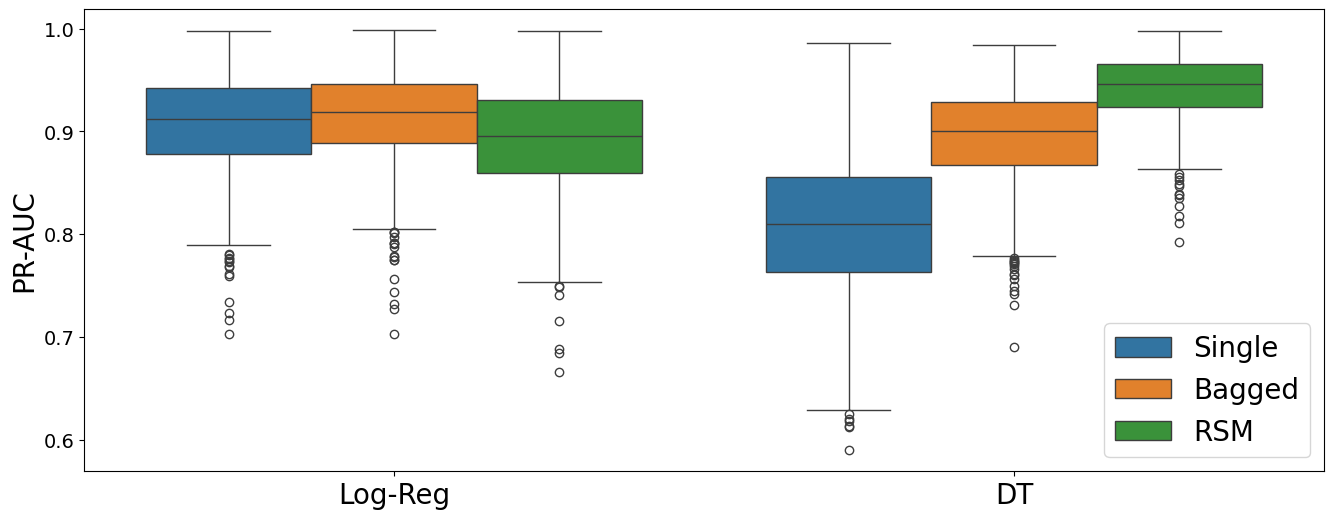

In [ ]:
plt.figure(figsize=(16, 6))

base_models = ["Log-Reg", "DT"] * 3
ensemble_types = ["Single"] * 2 + ["Bagged"] * 2 + ["RSM"] * 2
dfs = []
for i, model_name in enumerate(boot_scores):
    df = pd.DataFrame(boot_scores[model_name], columns=["pr_auc"])
    df["base_model"] = base_models[i]
    df["ensemble_method"] = ensemble_types[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="pr_auc", x="base_model", hue="ensemble_method")
plt.xlabel("", size=20)
plt.ylabel("PR-AUC", size=20)
plt.legend(fontsize=20, loc="lower right")
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)
plt.show()

RSM дополнительно повысил качество ансамбля, построенного на деревьях решений. Качество ансамбля, построенного на логистической регрессии, не улучшилось.

## Комбинация RSM и Bagging

Можно объединить оба способа: для каждой базовой модели в ансамбле применяем бутстрэп к объектам (получается выборка исходного размера, но с повторяющимися объектами), и дополнительно отбираем случайное подножество признаков. В этом случае мы получим еще более сильно отличающиеся друг от друга случайные выборки.

Для реализации комбинации RSM и Bagging в `BaggingClassifier` и `BaggingRegressor` требуется передать параметр `max_features` и `bootstrap=True`.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/rsm_and_bagging.png" width="300"/></center>

In [ ]:
# Both Bagging and RSM
models["BagRSM LogReg"] = BaggingClassifier(
    estimator=models["LogReg"].best_estimator_,
    n_estimators=100,
    bootstrap=True,
    max_features=sqrt_features,
    random_state=42,
).fit(x_train, y_train)

models["BagRSM DT"] = BaggingClassifier(
    estimator=models["DT"].best_estimator_,
    n_estimators=100,
    bootstrap=True,
    max_features=sqrt_features,
    random_state=42,
).fit(x_train, y_train)

In [ ]:
for name, model in models.items():
    predictions[name] = model.predict_proba(x_test)[:, 1]
    boot_scores[name] = bootstrap_metric(
        y_test.values,
        predictions[name],
        metric_fn=average_precision_score,  # PR-AUC
    )

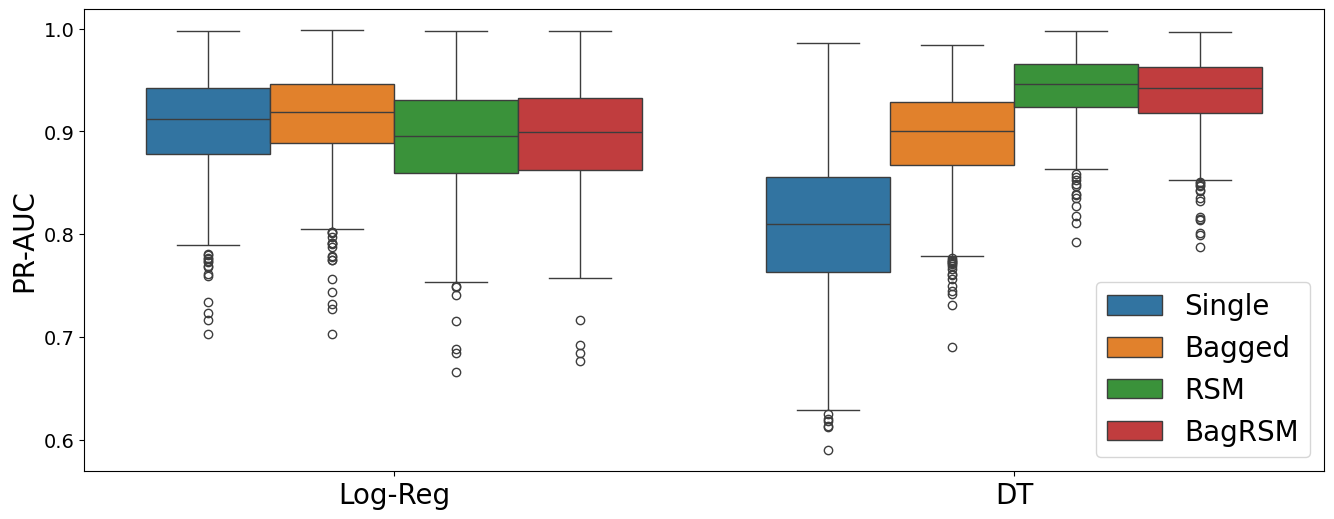

In [ ]:
plt.figure(figsize=(16, 6))

base_models = ["Log-Reg", "DT"] * 4
ensemble_types = ["Single"] * 2 + ["Bagged"] * 2 + ["RSM"] * 2 + ["BagRSM"] * 2

dfs = []
for i, model_name in enumerate(boot_scores):
    df = pd.DataFrame(boot_scores[model_name], columns=["pr_auc"])
    df["base_model"] = base_models[i]
    df["ensemble_method"] = ensemble_types[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="pr_auc", x="base_model", hue="ensemble_method")
plt.xlabel("", size=20)
plt.ylabel("PR-AUC", size=20)
plt.legend(fontsize=20, loc="lower right")
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)
plt.show()

Существенное улучшение качества при ансамблировании наблюдается только при использовании решающего дерева в качестве базовой модели.

Почему для одних классов моделей работает, а для других — нет?

Чтобы простое голосование повышало качество ансамбля, необходимо, чтобы ошибки базовых моделей не коррелировали между собой.

Попробуем оценить попарную корреляцию в ошибках базовых моделей в ансамблях.

In [ ]:
import itertools


def base_model_pair_correlation(ensemble, x):
    corrs = []
    for (i, est1), (j, est2) in itertools.combinations(
        enumerate(ensemble.estimators_), 2
    ):
        xi_test = x.values[:, ensemble.estimators_features_[i]]
        xj_test = x.values[:, ensemble.estimators_features_[j]]

        y_pred_t1 = est1.predict_proba(xi_test)[:, 1]
        y_pred_t2 = est2.predict_proba(xj_test)[:, 1]

        corrs.append(scipy.stats.pearsonr(y_pred_t1, y_pred_t2)[0])
    return np.array(corrs)

In [ ]:
pair_correlations = {}
for name, model in models.items():
    if not "Bagging" in name and not "RSM" in name:
        continue
    pair_correlations[name] = base_model_pair_correlation(model, x_test)

In [ ]:
cor_res = pd.DataFrame(pair_correlations)
cor_res = cor_res.melt(
    value_vars=cor_res.columns, value_name="paircor", var_name="model"
)


def read_base(s):
    return "DT" if "dt" in s.lower() else "Log-Reg"


def read_ensemble(s):
    return (
        ("BagRSM" if "rsm" in s.lower() else "Bagged")
        if "bag" in s.lower()
        else "Single"
    )


cor_res["base_model"] = cor_res["model"].apply(read_base)
cor_res["ensemble_method"] = cor_res["model"].apply(read_ensemble)

Кроме того, посчитаем качество базовых моделей, входящих в каждый из ансамблей.

In [ ]:
def base_model_prauc(ensemble, x, y):
    qual = np.zeros(ensemble.n_estimators)
    for ind, est in enumerate(ensemble.estimators_):
        x_test = x.values[:, ensemble.estimators_features_[i]]
        y_pred = est.predict_proba(x_test)[:, 1]
        qual[ind] = average_precision_score(y_score=y_pred, y_true=y)
    return qual

In [ ]:
base_prauc = {}
for name, model in models.items():
    if not "Bagging" in name and not "RSM" in name:
        continue
    base_prauc[name] = base_model_prauc(model, x_test, y_test)

In [ ]:
base_prauc_res = pd.DataFrame(base_prauc)
base_prauc_res = base_prauc_res.melt(
    value_vars=base_prauc_res.columns, value_name="pr_auc", var_name="model"
)
base_prauc_res["base_model"] = base_prauc_res["model"].apply(read_base)
base_prauc_res["ensemble_method"] = base_prauc_res["model"].apply(read_ensemble)

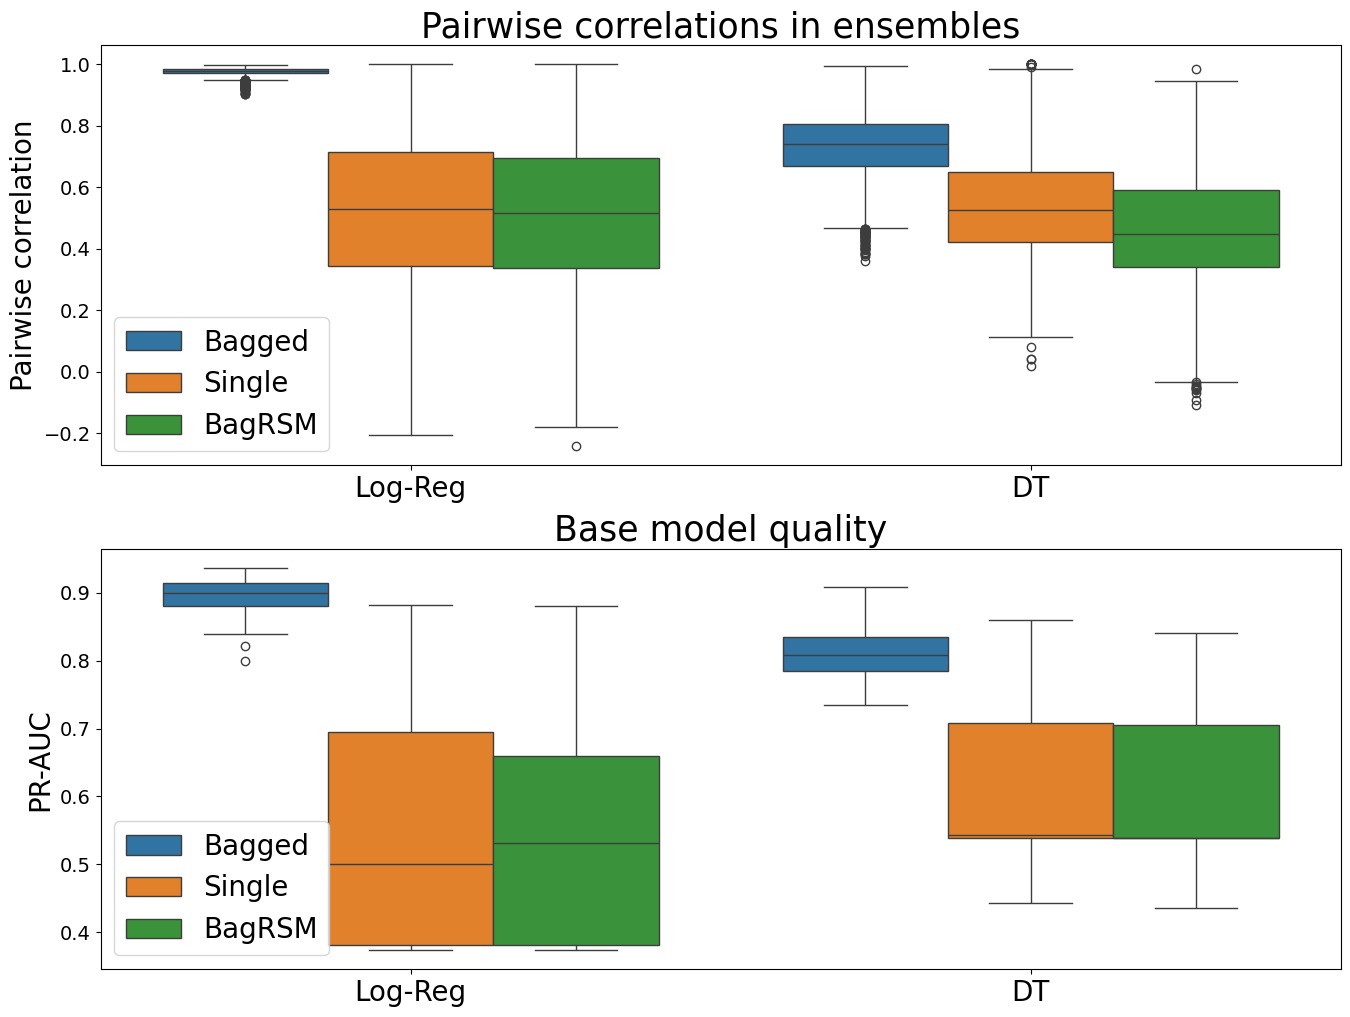

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(211)
sns.boxplot(data=cor_res, y="paircor", x="base_model", hue="ensemble_method")
plt.title("Pairwise correlations in ensembles", size=25)
plt.xlabel("", size=20)
plt.ylabel("Pairwise correlation", size=20)
plt.legend(fontsize=20, loc="lower left")
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)

plt.subplot(212)
sns.boxplot(data=base_prauc_res, y="pr_auc", x="base_model", hue="ensemble_method")
plt.title("Base model quality", size=25)
plt.xlabel("", size=20)
plt.ylabel("PR-AUC", size=20)
plt.subplots_adjust()
plt.legend(fontsize=20, loc="lower left")
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)

plt.show()

Можно сделать следующие выводы:

1. Bagging, RSM и их комбинация помогают уменьшать корреляцию между базовыми моделями. Причем, комбинация Bagging и RSM работает лучше, чем каждый из них поодиночке.
2. В случае Bagging дерево решений получает существенный прирост качества за счет того, что модели на его основе коррелированы значительно слабее, чем модели на основе логистической регрессии.
3. Отсутствие корреляции при RSM и BagRSM для Log-Reg связано с отсутствием важных признаков при обучении некоторых моделей. Предсказание моделей на разных выборках при одинаковых признаках будет мало отличаться. Из-за этого ансамбль на основе деревьев решений опять показывает лучший результат.